# Multi Batch Profiling Spec Proposal

### The goal of multi-batch profiling is to provide a description of a typical batch of data asset that is more reliable than the profiling built from a sample of one batch.

### Such description will help users learn the distribution of statistics and author expectations that capture the reasonable range of values while leaving out the outliers.

### This proposal describes the method of computing the results of multi-batch profiling and suggests the ways to visualize them in an informative way.

### This proposal does NOT address the logic of automatic suggestion of expectations based on the profiling results.



In [1]:
import json
import os
from collections import defaultdict
import great_expectations as ge
import great_expectations.jupyter_ux
import pandas as pd
from great_expectations.profile.basic_dataset_profiler import BasicDatasetProfiler


%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 4)
import altair as alt

from IPython.core.display import display, HTML


def acts_as_a_number(var):
    try: 0 + var
    except TypeError: return False
    else: return True    

2019-08-19T17:45:46-0700 - INFO - Great Expectations logging enabled at INFO level by JupyterUX module.


### Let's say we have 4 batches of the data asset "bechdel":


In [2]:
context = ge.data_context.DataContext()

In [3]:
my_ds = context.get_datasource("data-538__dir")
G = my_ds.get_generator()
G.reset_iterator('bechdel')
all_batch_kwargs = [x for x in G._data_asset_iterators['bechdel']]
all_batch_kwargs = sorted(all_batch_kwargs, key=lambda x: x['path'])
all_batch_kwargs

[{'path': '/Users/eugenemandel/project_data/data-538/bechdel/movies.csv',
  'timestamp': 1566261946.8228538,
  'sep': None,
  'engine': 'python'},
 {'path': '/Users/eugenemandel/project_data/data-538/bechdel/movies_201901.csv',
  'timestamp': 1566261946.822853,
  'sep': None,
  'engine': 'python'},
 {'path': '/Users/eugenemandel/project_data/data-538/bechdel/movies_201902.csv',
  'timestamp': 1566261946.8228512,
  'sep': None,
  'engine': 'python'},
 {'path': '/Users/eugenemandel/project_data/data-538/bechdel/movies_201903.csv',
  'timestamp': 1566261946.822845,
  'sep': None,
  'engine': 'python'}]

### Requirement: batches must be sortable in time. This most likely requires introducing the concept of **batch id**

For our example we will define a method that will derive batch id from the batch kwargs:

In [4]:
def get_batch_id(batch_kwargs):
    return os.path.basename(batch_kwargs['path'])

### Let's profile these batches one by one using our BasicProfiler:

##### (in reality we will read the validation results of individual batches from the validation store)

In [5]:
batch_profiling_results = []
batch_indices = []

profiler = BasicDatasetProfiler

In [6]:

for batch_kwargs_set in all_batch_kwargs:
    batch = context.get_batch('bechdel', expectation_suite_name='basic_must_pass_expectations', batch_kwargs=batch_kwargs_set)
    expectation_suite, validation_result = profiler.profile(batch, run_id="profiling_" + get_batch_id(batch._batch_kwargs))
    batch_profiling_results.append(validation_result)
    batch_indices.append(get_batch_id(batch._batch_kwargs))

2019-08-19T17:45:48-0700 - INFO -             Preparing column 0 of 15: year
2019-08-19T17:45:48-0700 - INFO -             Preparing column 1 of 15: imdb
2019-08-19T17:45:48-0700 - INFO -             Preparing column 2 of 15: title
2019-08-19T17:45:48-0700 - INFO -             Preparing column 3 of 15: test
2019-08-19T17:45:48-0700 - INFO -             Preparing column 4 of 15: clean_test
2019-08-19T17:45:48-0700 - INFO -             Preparing column 5 of 15: binary
2019-08-19T17:45:48-0700 - INFO -             Preparing column 6 of 15: budget
2019-08-19T17:45:48-0700 - INFO -             Preparing column 7 of 15: domgross
2019-08-19T17:45:48-0700 - INFO -             Preparing column 8 of 15: intgross
2019-08-19T17:45:48-0700 - INFO -             Preparing column 9 of 15: code
2019-08-19T17:45:48-0700 - INFO -             Preparing column 10 of 15: budget_2013$
2019-08-19T17:45:48-0700 - INFO -             Preparing column 11 of 15: domgross_2013$
2019-08-19T17:45:48-0700 - INFO -    

In [7]:
batch_indices
# batch_profiling_results

['movies.csv', 'movies_201901.csv', 'movies_201902.csv', 'movies_201903.csv']

### Multi-Batch profiling can be implemented as following:
### 1. Take list of validation results that were produced by profiling individual batches and 
### 2. Build a dataframe of metrics from the validation results where every column holds one metric and every row corresponds to one batch.
### 3. Visualize the distribution of the metrics' values over batches


### This proposal describes possible visualizations for individual metrics, but does not describe the overall UI - please suggest and I will document in the next version.

### What are these metrics? Metrics depend on expectation types. Below we will group expectation types by the metrics they produce.


### This is the list of all expectation types BasicProfiler uses:

In [8]:
all_exp_types_in_profiler = set([result['expectation_config']['expectation_type'] for result in batch_profiling_results[0]['results']])
all_exp_types_in_profiler

{'expect_column_distinct_values_to_be_in_set',
 'expect_column_kl_divergence_to_be_less_than',
 'expect_column_max_to_be_between',
 'expect_column_mean_to_be_between',
 'expect_column_median_to_be_between',
 'expect_column_min_to_be_between',
 'expect_column_proportion_of_unique_values_to_be_between',
 'expect_column_quantile_values_to_be_between',
 'expect_column_stdev_to_be_between',
 'expect_column_unique_value_count_to_be_between',
 'expect_column_values_to_be_between',
 'expect_column_values_to_be_in_set',
 'expect_column_values_to_be_in_type_list',
 'expect_column_values_to_be_unique',
 'expect_column_values_to_not_be_null',
 'expect_column_values_to_not_match_regex',
 'expect_table_columns_to_match_ordered_list',
 'expect_table_row_count_to_be_between'}

### 1. Aggregate expectations with single numeric observed value in the result

For these expectations we will show:
* a histogram that shows the distribution of the observed value - user will be able to see the typical values vs outliers.
* a line graph with X=batch ids and Y=observed value - the user will be able to see the change of the observed values over time

<img src="observed_val.jpg" alt="observed_val" style="width: 800px;"/>

### This is the list of expectation types in this group:


In [17]:
def result_contains_numeric_observed_value(result):
    return ('observed_value' in result['result']\
            and acts_as_a_number(result['result'].get('observed_value')))\
            and set(result['result'].keys()) <= set(['observed_value', 'element_count', 'missing_count', 'missing_percent'])

tmp1 = [result for result in batch_profiling_results[0]['results'] if result_contains_numeric_observed_value(result)
]

exp_types_with_numeric_observed_val = set([result['expectation_config']['expectation_type'] for result in tmp1])
exp_types_with_numeric_observed_val

{'expect_column_max_to_be_between',
 'expect_column_mean_to_be_between',
 'expect_column_median_to_be_between',
 'expect_column_min_to_be_between',
 'expect_column_proportion_of_unique_values_to_be_between',
 'expect_column_stdev_to_be_between',
 'expect_column_unique_value_count_to_be_between',
 'expect_table_row_count_to_be_between'}

### 2. Column map expectations - `unexpected_percent` in the result

For these expectations we will show:
* a histogram that shows the distribution of the unexpected percent - user will be able to see the typical values vs outliers.
* a line graph with X=batch ids and Y=observed value - the user will be able to see the change of the unexpected percent over time

<img src="observed_val.jpg" alt="observed_val" style="width: 800px;"/>

### This is the list of expectation types in this group:


In [18]:
def result_contains_unexpected_pct(result):
    return 'unexpected_percent' in result['result']\
        and result['expectation_config']['expectation_type'] != 'expect_column_values_to_be_in_set'


tmp1 = [result for result in batch_profiling_results[0]['results'] if result_contains_unexpected_pct(result)]

exp_types_with_unexp_pct = set([result['expectation_config']['expectation_type'] for result in tmp1])
exp_types_with_unexp_pct

{'expect_column_values_to_be_between',
 'expect_column_values_to_be_in_type_list',
 'expect_column_values_to_be_unique',
 'expect_column_values_to_not_be_null',
 'expect_column_values_to_not_match_regex'}

### 3. Every expectation type in the remaining group requires special processing:

In [19]:
all_exp_types_in_profiler-exp_types_with_unexp_pct-exp_types_with_numeric_observed_val

{'expect_column_distinct_values_to_be_in_set',
 'expect_column_kl_divergence_to_be_less_than',
 'expect_column_quantile_values_to_be_between',
 'expect_column_values_to_be_in_set',
 'expect_table_columns_to_match_ordered_list'}

### expect_column_distinct_values_to_be_in_set

* {"cat", "dog", "bird", "fish"} is a union of value sets of all the batches.
* QUESTION: This presentation covers the case of a column not being present in all batches, but not the case of columns changing order. Proposals?


<img src="expect_column_distinct_values_to_be_in_set.jpg" alt="expect_column_distinct_values_to_be_in_set" style="width: 400px;"/>


### expect_column_kl_divergence_to_be_less_than

Since the bins might be different in different batches, we should stack the individual batches' histograms on a shared X axis:

<img src="expect_column_kl_divergence_to_be_less_than.jpg" alt="expect_column_distinct_values_to_be_in_set" style="width: 400px;"/>

Question: is there a reasonable way to stack the histograms horizontally?


### expect_column_quantile_values_to_be_between

For each of the five quantiles that BasicProfiler computes we will display a visualization similar to the one we used for observed values and unexpected percentage:
* a line graph showing the value of the quantile over batch ids
* a histogram showing the distribution of the quantile value (NOT SHOWN IN THE DRAWING)

<img src="expect_column_quantile_values_to_be_between.jpg" alt="expect_column_quantile_values_to_be_between" style="width: 400px;"/>


### expect_table_columns_to_match_ordered_list

Each row in the visualization corresponds to one column of the original dataset. Each column corresponds to a batch.
* "v": the column is present in the batch
* "x": the column is missing from the batch
* {"claim_id", "user_id", "status", "visit_date"} is a union of column names of all the batches.


<img src="expect_table_columns_to_match_ordered_list.jpg" alt="expect_table_columns_to_match_ordered_list" style="width: 400px;"/>

This covers the case of a column missing in some batches, but not a change in the order


### expect_column_values_to_be_in_set

Question: not sure how to visualize it in a clear way over batches - suggestions?

### Here is an example of `partial_unexpected_counts` in the result:

In [15]:
[result['result']['partial_unexpected_counts'] for result in batch_profiling_results[0]['results'] if result['expectation_config']['expectation_type'] == 'expect_column_values_to_be_in_set'][0]


[{'value': 2010, 'count': 129},
 {'value': 2009, 'count': 124},
 {'value': 2011, 'count': 124},
 {'value': 2008, 'count': 101},
 {'value': 2005, 'count': 100},
 {'value': 2013, 'count': 99},
 {'value': 2006, 'count': 90},
 {'value': 2012, 'count': 86},
 {'value': 2004, 'count': 81},
 {'value': 2002, 'count': 80},
 {'value': 2007, 'count': 73},
 {'value': 2001, 'count': 64},
 {'value': 2003, 'count': 64},
 {'value': 2000, 'count': 63},
 {'value': 1998, 'count': 62},
 {'value': 1999, 'count': 56},
 {'value': 1997, 'count': 51},
 {'value': 1996, 'count': 42},
 {'value': 1995, 'count': 36},
 {'value': 1994, 'count': 26}]

In [14]:
#[result for result in batch_profiling_results[0]['results'] if result['expectation_config']['expectation_type'] == 'expect_column_quantile_values_to_be_between']
#[result for result in batch_profiling_results[0]['results'] if result['expectation_config']['expectation_type'] == 'expect_column_kl_divergence_to_be_less_than']
[result for result in batch_profiling_results[0]['results'] if result['expectation_config']['expectation_type'] == 'expect_column_values_to_be_in_set']
[result for result in batch_profiling_results[0]['results'] if result['expectation_config']['expectation_type'] == 'expect_column_distinct_values_to_be_in_set']
[result['result']['partial_unexpected_counts'] for result in batch_profiling_results[0]['results'] if result['expectation_config']['expectation_type'] == 'expect_column_values_to_be_in_set'][0]


# tmp1 = [result for result in batch_profiling_results[0]['results'] if\
# (not  (result['result'].get('observed_value') and acts_as_a_number(result['result'].get('observed_value'))\
#  or 'unexpected_percent' in result['result'])) and result['expectation_config']['expectation_type']
# ]

# # [result for result in batch_profiling_results[0]['results'] if\
# #  result['result'].get('unexpected_percent')
# # ]


# set([result['expectation_config']['expectation_type'] for result in tmp1])

# # tmp1

# [result for result in batch_profiling_results[0]['results'] if result['expectation_config']['expectation_type'] == 'expect_column_mean_to_be_between']




[{'value': 2010, 'count': 129},
 {'value': 2009, 'count': 124},
 {'value': 2011, 'count': 124},
 {'value': 2008, 'count': 101},
 {'value': 2005, 'count': 100},
 {'value': 2013, 'count': 99},
 {'value': 2006, 'count': 90},
 {'value': 2012, 'count': 86},
 {'value': 2004, 'count': 81},
 {'value': 2002, 'count': 80},
 {'value': 2007, 'count': 73},
 {'value': 2001, 'count': 64},
 {'value': 2003, 'count': 64},
 {'value': 2000, 'count': 63},
 {'value': 1998, 'count': 62},
 {'value': 1999, 'count': 56},
 {'value': 1997, 'count': 51},
 {'value': 1996, 'count': 42},
 {'value': 1995, 'count': 36},
 {'value': 1994, 'count': 26}]

### Code snippet for extracting metrics from results 
### (covers only observed values and unexpected percentages)

In [16]:
def get_metric_name_and_value(result):
#     print(json.dumps(result, indent=2))
    new_metric_name = None
    new_metric_value = None
    if result.get('result'):
        if result_contains_numeric_observed_value(result):
            if result['expectation_config']['kwargs'].get('column'):
                new_metric_name = result['expectation_config']['kwargs']['column'] + "__" + result['expectation_config']['expectation_type'] + "__obsval"
            else:
                new_metric_name = result['expectation_config']['expectation_type'] + "__obsval"

            new_metric_value = result.get('result').get('observed_value')
        elif result_contains_unexpected_pct(result):
            if result['expectation_config']['kwargs'].get('column'):
                new_metric_name = result['expectation_config']['kwargs']['column'] + "__" + result['expectation_config']['expectation_type'] + "__unexp"
            else:
                new_metric_name = result['expectation_config']['expectation_type'] + "__unexp"

            new_metric_value = result.get('result').get('unexpected_percent')

    return (new_metric_name, new_metric_value)


### Can a validation result of an expectation have more than one metric?

### No reason to store anything by the validation results of batches. It is fast to recompute the metrics dataframe from them in memory.

In [65]:


metrics = defaultdict(list)

metrics["batch_index"] = batch_indices

for j, evrs in enumerate(batch_profiling_results):
    for i, result in enumerate(evrs['results']):
#         print(j, i)
        new_metric_name, new_metric_value = get_metric_name_and_value(result)
        if new_metric_name and new_metric_value:
            metrics[new_metric_name].append(new_metric_value)

            
metrics_df = pd.DataFrame(metrics)  
metrics_df

,batch_index,expect_table_row_count_to_be_between__obsval,year__expect_column_unique_value_count_to_be_between__obsval,year__expect_column_proportion_of_unique_values_to_be_between__obsval,year__expect_column_values_to_be_in_set__unexp,year__expect_column_min_to_be_between__obsval,year__expect_column_max_to_be_between__obsval,year__expect_column_mean_to_be_between__obsval,year__expect_column_median_to_be_between__obsval,year__expect_column_stdev_to_be_between__obsval,...,intgross_2013$__expect_column_mean_to_be_between__obsval,intgross_2013$__expect_column_median_to_be_between__obsval,period code__expect_column_unique_value_count_to_be_between__obsval,period code__expect_column_proportion_of_unique_values_to_be_between__obsval,period code__expect_column_values_to_not_be_null__unexp,period code__expect_column_values_to_be_in_set__unexp,decade code__expect_column_unique_value_count_to_be_between__obsval,decade code__expect_column_proportion_of_unique_values_to_be_between__obsval,decade code__expect_column_values_to_not_be_null__unexp,decade code__expect_column_values_to_be_in_set__unexp
0,movies.csv,1794,44,0.024526,1.0,1970,2013,2002.552397,2005.0,8.979731,...,1.978380e+08,96239640.0,5,0.003096,0.099777,0.900223,3,0.001858,0.099777,0.900223
1,movies_201901.csv,1794,44,0.024526,1.0,1970,2013,2002.552397,2005.0,8.979731,...,1.978380e+08,96239640.0,5,0.003096,0.099777,0.900223,3,0.001858,0.099777,0.900223
2,movies_201902.csv,1794,44,0.024526,1.0,1970,2013,2002.552397,2005.0,8.979731,...,1.978380e+08,96239640.0,5,0.003096,0.099777,0.900223,3,0.001858,0.099777,0.900223
3,movies_201903.csv,1794,44,0.024526,1.0,1970,2013,2002.552397,2005.0,8.979731,...,1.978380e+08,96239640.0,5,0.003096,0.099777,0.900223,3,0.001858,0.099777,0.900223


In [66]:

# display(HTML('<h1>Hello, world!</h1>'))

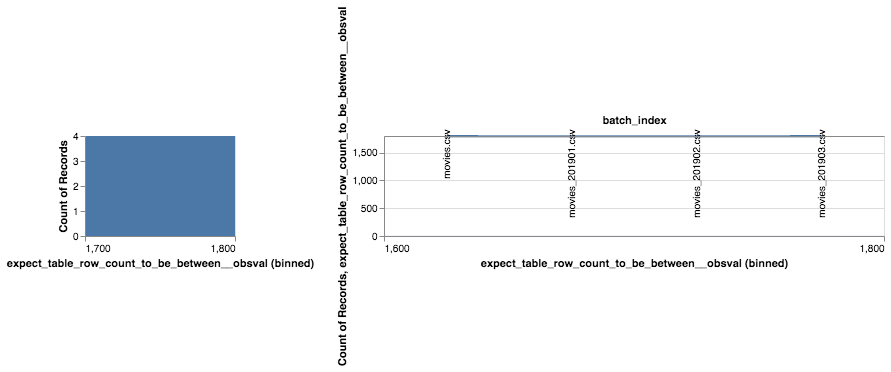

In [69]:
def create_plots(metrics_df, col):
    bars = alt.Chart(metrics_df).mark_bar().encode(
        alt.X(col, bin=True),
        y='count()',
    )
    
    lines = alt.Chart(metrics_df).mark_line().encode(
        x='batch_index',
        y=col,
    )

    # text = lines.mark_text(align='left', dx=5, dy=-5).encode(
    #     text=alt.condition(nearest, 'y:Q', alt.value(' '))
    # )

    layer = alt.layer(
        bars, lines
    ).properties(
        width=500,
        height=100
    )


    chart2 = alt.Chart(metrics_df).mark_bar().encode(
        y='count()',
        x=alt.Y(col+':Q', bin=alt.Bin(maxbins=30)),
    #     color='species:N'
    ).properties(
        height=100,
        width=150
    )

    return( chart2 | layer )
#     return layer
#     display(chart2 | layer)
create_plots(metrics_df, "expect_table_row_count_to_be_between__obsval")